## 11.1 Stochastic Gradient Descent

In this exercise, we will improve our previous basic MLP by extending it to use stochastic gradient descent and more advanced weight updates. But before we do so, we can also upgrade our dataset to the _California_ Housing dataset! The code below will download this dataset and do a training / validation split into 20000 training samples and 640 validation samples.

We will normalize the features again, but this time we use min-max normalization. Each feature is transformed as follows:

$$ f' = \frac{f - f_\text{min}}{f_\text{max} - f_\text{min}} $$

**Q 11.1.1: What are the differences to Z-Score normalization in 5.2?**

all values are within a range from 0 to 1 
in Z-Score the values are centered around zero, and all have the same relative variance -
but outlier-values could be far out

In [1]:
import os
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.utils import shuffle

n_training_samples = 20000

# Download the dataset into the notebook directory, if
# it doesn't exist yet
california = fetch_california_housing(data_home=os.getcwd())
#print("calfornia_shape {}".format(california))
# Randomize the order of the samples
data, target = shuffle(california.data, california.target)
print("data {} target {}".format(data.shape, target.shape))


# Split into training and validation dataset
X_train = data[:n_training_samples]
y_train = target[:n_training_samples].reshape((-1, 1))
#y_train = target[:n_training_samples]
#print("X_train {},  y_train {}".format(X_train.shape, y_train.shape))
#print("y_train", y_train)
#print("X_train", X_train)
X_valid = data[n_training_samples:]
y_valid = target[n_training_samples:].reshape((-1, 1))

# Determine minimum and maximum of training data
X_min = np.min(X_train, axis=0)
X_max = np.max(X_train, axis=0)
y_min = np.min(y_train)
y_max = np.max(y_train)

# Scale the features accordingly. We want them to be in
# the range[-1, 1], so we multiply with 2 and subtract 1.
X_train = 2 * (X_train - X_min) / (X_max - X_min) - 1
X_valid = 2 * (X_valid - X_min) / (X_max - X_min) - 1
y_train = 2 * (y_train - y_min) / (y_max - y_min) - 1
y_valid = 2 * (y_valid - y_min) / (y_max - y_min) - 1

data (20640, 8) target (20640,)


The following code sets up the neural network and defines its forward and backward pass. It is the same as in the solution to exercise 5.2, so if you are not sure how it works, now would be a good time to find out! Otherwise you can execute it and skip to the next block.

In [2]:
# Define the network architecture
n_input_units = X_train.shape[1]
n_hidden_units = 50
n_output_units = 1

# Every layer is a matrix multiplication plus a bias, so
# the shapes must match those operations.
hidden_weights_shape = (n_input_units, n_hidden_units)
output_weights_shape = (n_hidden_units, n_output_units)
hidden_bias_shape = (1, n_hidden_units)
output_bias_shape = (1, n_output_units)

# For the optimization with gradient descent, we have to pick an
# initial guess for the solution.
def init_weights():
    # We initialize the weights with a Gaussian distribution
    hidden_weights = np.random.standard_normal(hidden_weights_shape) * 0.1
    output_weights = np.random.standard_normal(output_weights_shape) * 0.1

    # The bias is usually initialized to zero
    hidden_bias = np.zeros(hidden_bias_shape)
    output_bias = np.zeros(output_bias_shape)

    return hidden_weights, output_weights, hidden_bias, output_bias
    
hidden_weights, output_weights, hidden_bias, output_bias = init_weights()
    
# Activation functions
def relu(x):
    # It's important to use the elementwise max function in numpy
    return np.maximum(0., x)

def linear(x):
    return x

# The forward pass for this neural network
# The output for every layer should be computed in
# two steps: before and after applying the activation
# function.
def forward_pass(X):
    hidden_linear = X.dot(hidden_weights) + hidden_bias
    hidden_act = relu(hidden_linear)
    
    output_linear = hidden_act.dot(output_weights) + output_bias
    output_act = linear(output_linear)
    
    # We collect the activations in a dictionary here,
    # because we need them for the backward pass
    activations = {
        'hidden_linear': hidden_linear,
        'hidden_act': hidden_act,
        'output_linear': output_linear,
        'output_act': output_act
    }
    
    # The prediction is in output_act
    return output_act, activations

# Loss function
# Implement the mean square error function
def squared_error(y_predicted, y):
    return np.mean(0.5 * (y_predicted - y)**2)

# For the backward pass, we will need the
# derivatives of the activation functions and the loss function
# The gradients are defined in the slides, we just need to match
# the input shapes.
def relu_grad(x):
    dx = np.zeros_like(x)
    dx[x > 0] = 1.
    return dx

def linear_grad(x):
    return np.ones_like(x)

# The error gradient wrt the predicted y value
def squared_error_grad(y_hat, y):
    n_samples = float(y.shape[0])
    return (y_hat - y) / n_samples

# The backward pass is responsible for calculating the derivatives
# of the loss with respect to the weights and biases of each layer.
# It also helps to think about the shapes (again!)
def  backward_pass(X, y, activations):  
    # The first thing to calculate is the gradient of the error function wrt
    # the prediction the network made
    error_grad = squared_error_grad(activations['output_act'], y)
    
    # Now we can go backwards layer by layer
    # First derive wrt the activation function, because it is the last thing we did in
    # the forward pass
    output_act_grad = error_grad * linear_grad(activations['output_linear']) 
    
    # Two objects contributed to Xw + b: the weights and the bias
    # These are the parameters of our network and will let us update
    # the network later.
    output_weights_grad = activations['hidden_act'].T.dot(output_act_grad)
    
    # Remember that the bias was broadcasted from its shape (1, k) to 
    # (n, k) with n being the number of samples. For the correct gradient
    # you need to get back to (1, k) by summing up.
    output_bias_grad = output_act_grad.sum(axis=0, keepdims=True) # keepdims: If this is set to True, the axes which are reduced are left in the result as dimensions with size one. With this option, the result will broadcast correctly against the input array.
    
    # The last thing to do for the output layer is to take the derivative wrt
    # its input, so we can backpropagate the errors the previous layers need
    # to fix.
    output_inp_grad = output_act_grad.dot(output_weights.T)

    # From here on, everything is the same as for the output layer, except
    # for the changed activation function
    hidden_act_grad = output_inp_grad * relu_grad(activations['hidden_linear'])
    hidden_weights_grad = X.T.dot(hidden_act_grad)
    hidden_bias_grad = hidden_act_grad.sum(axis=0, keepdims=True)
    
    # These are the gradients we care about in the end, because
    # we need them to update our network
    gradients = (
        output_weights_grad,
        output_bias_grad,
        hidden_weights_grad,
        hidden_bias_grad
    )
    
    return gradients

Stochastic gradient descent relies on using fewer samples to estimate the gradient in the backward pass. The code below still performs full-batch gradient descent as in the previous exercise, but has been restructured a little bit. Get familiar with it and try it out before you solve the tasks.

** Task a): Implement mini-batch training**

Change the training loop in the code below to go through the training data in mini-batches of 100 samples each. Adjust the training loss to reflect the average error over the mini-batches.



** Q 11.1.2: How does mini-batch training influence the number of weight updates? **
weight updates any 100 (or whatever mini-batch-size) instead of 20.000 datasets --> factor 200 times more updates

** Q 11.1.3: How do the training time in seconds and the performance change? **

Similar final loss on validation data of 0.05 can be reached either by "full" batch option or "mini" batch option

- with "full" option and Learning rate much larger (0,1), and after about 10 seconds (200 epochs) 
    or 100 epochs and learning rate of 0,5. at even larger learning rates the sytems doesent converge any more (gets instable)

- with "mini" option and batch size 100 at learning rate 0.01 the same performance is reached after only 10 epochs
  at a learning rate of 0.1 after only 1 to 2 epochs

--> same result at 10 to 100 times higher speed, without risk of destabilising the system by very large learning rates

can be further optimised with smaller mini batch sizes (20). Fully trained after only one epoch
when using only size one for the mini batches, the loss gets slightly higher (~0.6 instead of 0.5)

----------------------

# ** Task b): Implement Adam**

Change the `update_network` function to perform adaptive moment (adam) weight updates. Use the default parameters from the [deep learning book (p. 311)](http://www.deeplearningbook.org/contents/optimization.html), except for $\rho_2 = 0.95$.

_Python hints_: 

  * To focus on the actual implementation here, we use the [global](http://www.python-course.eu/python3_global_vs_local_variables.php) keyword to keep track of $t$.
  * In the `update_network` function, assign updated values via `"parameters[i][:] = "` and not `"parameters[i] = "`. The first variant changes the underlying object, while the second simply assigns a new object to the list element. Check the vanilla gradient descent variant for an example. The same should be done for the running means!

** Q 11.1.4: Why does Adam fit to SGD? **
Compared to batch method SGD (mini batches) will have more noisy gradients, because they are based on the average of a much smaller number of samples. Adam can smooth this noise in gradient parameters, by relying on a weighted moving average of the gradients instead of the latest gradient. 

Test of this hypothesis: 
with minibatch_size = 20, running only one epoch, "vanilla" update method yields validation error of about 0.1, "adam" yields already 0.043 which is about the best error rate achievable. 

** Q 11.1.5: What is the difference in space complexity between Adam and vanilla gradient descent?**
Cant see a big difference. Adam has three Weight parameters instead of one, (parameters plus s plus r, both having the same shape). But space requirement of weight parameters should be much smaller in this case, because number of Samples is much larger than number of weights in this case. (might be different with networks with more weight parameters than samples) 

Gradient estimation method: mini
Weight update method: adam
training_loss 0.05366047812980821, run 0
valid_loss 0.042192604621148856, run 0
training_loss 0.042248642012141256, run 1
valid_loss 0.04057949620916399, run 1
training_loss 0.041094758137814484, run 2
valid_loss 0.03954174083995293, run 2
training_loss 0.0401867383523355, run 3
valid_loss 0.03884326546823021, run 3
training_loss 0.03953931586938087, run 4
valid_loss 0.03830403403317441, run 4
training_loss 0.038979385818104985, run 5
valid_loss 0.03778252458520203, run 5
training_loss 0.038516577616572546, run 6
valid_loss 0.0373416808910768, run 6
training_loss 0.03812007027074841, run 7
valid_loss 0.03694687334878054, run 7
training_loss 0.03779313337382928, run 8
valid_loss 0.036457154811310385, run 8
training_loss 0.03750302207693622, run 9
valid_loss 0.03628397775225058, run 9
training_loss 0.03724299465677523, run 10
valid_loss 0.03605579780444328, run 10
training_loss 0.03703942920065295, run 11
valid_loss 0.0357078646

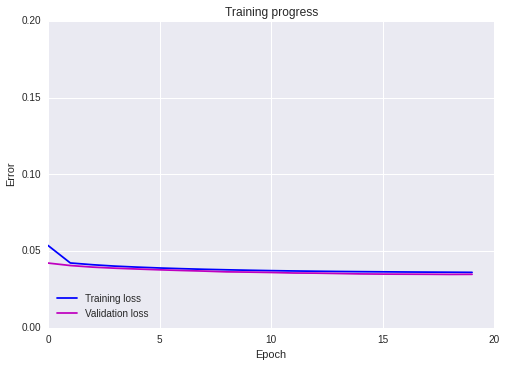

In [3]:
# If you have matplotlib 1.5 or higher, we can use live plotting!
import matplotlib as mpl
if float(mpl.__version__[:3]) >= 1.5:
    %matplotlib notebook
else:
    %matplotlib inline
    
import matplotlib.pyplot as plt
import seaborn
import time

# Hyperparameters
n_epochs = 20
learning_rate = 0.001

# Decide on the gradient estimation method. Should be 'full' or 'mini'.
# After implementing a) you can switch here between both methods.
batch_method = 'mini'
minibatch_size = 20

# Decide on the update method. Should be 'vanilla' or 'adam'
# After implementing b) you can switch here between both methods.
update_method = 'adam'

# Hyperparameters for Adam
# TODO b)

# Describes how many epochs are done without plotting
# In case the plotting takes too much performance, you can set it higher
# update_plot > n_epochs disables plotting.
update_plot = 1

# We keep track of training and validation error
# for every episode.
training_loss = np.ones(n_epochs) * np.nan
valid_loss = np.ones(n_epochs) * np.nan
epoch_time = np.ones(n_epochs) * np.nan

# Storing the parameters in a list for simple access
hidden_weights, output_weights, hidden_bias, output_bias = init_weights()
parameters = [output_weights, output_bias, hidden_weights, hidden_bias]

# Plotting code:
# This time we update the plot live during training.
# Before we start training, let's also print the current methods
print('Gradient estimation method: {:s}'.format(batch_method))
print('Weight update method: {:s}'.format(update_method))
fig, ax = plt.subplots(1, 1)
ax.set_title('Training progress')
ax.set_xlim([0, n_epochs])
ax.set_ylim([0, 0.5])
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')
def plot(ax):
    if ax.lines:
        ax.lines[0].set_ydata(training_loss)
        ax.lines[1].set_ydata(valid_loss)
        ax.set_ylim([0,  0.2])
    else:
        ax.plot(training_loss, c='b', label='Training loss')
        ax.plot(valid_loss, c='m', label='Validation loss')
        ax.legend(loc='lower left')
    fig.canvas.draw()
# -- end of plotting code

# Bookkeeping for Adam
t = 0

# Create the running means for the gradients and squared gradients
# with list comprehensions. This is a quick notation to loop through
# every element in the parameters list
# initialise s and r with same structure as Parameters (weights, biases)
s = [np.zeros_like(p) for p in parameters]
#print("s {}".format(s))
r = [np.zeros_like(p) for p in parameters]
s_hat = [np.zeros_like(p) for p in parameters]
r_hat = [np.zeros_like(p) for p in parameters]


sigma = 1e-8
ro1, ro2 = 0.9, 0.95

# Update the parameters (global List with weights and biases) of the network given the gradients 
# from the backward pass
def update_network(gradients, parameters):
    
    # First determine which update method is going to be used
    if update_method.lower() == 'adam':
        global t,s,r, s_hat, r_hat
        t += 1 # counter for use in compensating bias effect
        
        for i, grad in enumerate(gradients):
        
            # weight update for each parameter individually --> elementwise calculation, use of hadamard products, 
            # update first and second order momentums recursively, thus storing the "history" of the gradient / grad-variance
            # decay parameters ro1/2 lead to exponential "decay" of terms in far past, in order to better adapt to 
            # current environment of gradient-"landscape"
            # update first order momentum - positive momentum term, as in Slide 16,24 "SDG with momentum"
            s[i][:] = ro1*s[i] + (1-ro1)*grad
            # update second order momentum - "variance", 
            r[i][:] = ro2*r[i] + (1-ro2)*np.multiply(grad,grad)  # hadamard product of gradient, elementwise 
        
            s_hat[i][:] = np.divide(s[i] , 1 - np.power(ro1,t)) # compensate for bias effect by decay parameters
            r_hat[i][:] = np.divide(r[i] , 1 - np.power(ro2,t)) 
        
            # numerator s: delta increases with large accumulated momentum 
            # >> faster transition of regions with low gradient
            # denominator r: delta decreases with large accumulated gradient variance: 
            # >> slower movement in complex terrain in order to fit into small local minimal without diverging
            delta_params = - learning_rate * np.divide(s_hat[i],(np.sqrt(r_hat[i]) + sigma)) # elementwise division
            #delta_params = - learning_rate * np.divide(s[i],(np.sqrt(r[i]) + sigma)) # elementwise division

            
            # elementwise division and square root
            #parameters[i][:] = parameters[i] - learning_rate * np.divide(s_hat[i],(np.sqrt(r_hat[i]) + sigma)) 
            parameters[i][:] = parameters[i] - learning_rate * np.divide(s[i],(np.sqrt(r[i]) + sigma)) 
            
    else:
        # For the vanilla gradient descent update, we can simply
        # loop through the gradients and parameters and update
        # them with the scaled gradient
        for i, grad in enumerate(gradients):
            # Be careful to use the same notation to assign the parameters!
            # Taking the slice with [:] means changing the underlying object,
            # while just = assigns a new one. 
            parameters[i][:] = parameters[i] - learning_rate * grad

# Define the number of minibatches, so we can loop over them easily
n_minibatches = X_train.shape[0] // minibatch_size

# The training loop
for i in range(n_epochs):
    start = time.time()
    
    # Decide on the method we use to estimate the gradient
    if batch_method.lower() == 'mini':
        # run through mini-batches and perform update forward and backward pass, yielding new gradients at any step
        this_training_loss = 0
        for j in range(n_minibatches):
            # slicing training data in mini packages
            X_train_mini = X_train[j * minibatch_size : (j+1) * minibatch_size]
            y_train_mini = y_train[j * minibatch_size : (j+1) * minibatch_size].reshape((-1, 1))

            y_pred_mini, activations = forward_pass(X_train_mini)
            gradients = backward_pass(X_train_mini, y_train_mini, activations)

            update_network(gradients, parameters)
                  
            this_training_loss += squared_error(y_pred_mini, y_train_mini)
            #print("gaga",this_training_loss)

        # average training loss over the mini_batches
        training_loss[i] = this_training_loss / n_minibatches
        print("training_loss {}, run {}".format(training_loss[i],i))
    else:
        # For the full batch case, we use all the training samples
        # to estimate the gradient
        y_pred, activations = forward_pass(X_train)
        gradients = backward_pass(X_train, y_train, activations)
    
        # Update the parameters of the network with the gradients
        # we just computed.
        update_network(gradients, parameters) 
    
        # Save the training loss for this epoch
        training_loss[i] = squared_error(y_pred, y_train)
    
    # Measure the time it took to perform the training in this epoch
    epoch_time[i] = time.time() - start
    
    # Evaluate the validation set and save the loss for later
    y_pred_valid, _ = forward_pass(X_valid)  # resulting activations not needed in this case
    valid_loss[i] = squared_error(y_pred_valid, y_valid)
    print("valid_loss {}, run {}".format(valid_loss[i],i))
        
    # Update the plot
    if i % update_plot == 0 or i == n_epochs - 1:
        plot(ax)
        
# Print statistics about the training process
print('Results:')
print('\tFinal training loss: {:.5f}'.format(training_loss[-1]))
print('\tFinal validation loss: {:.5f}'.format(valid_loss[-1]))
print('\n\tAverage epoch time: {:.3f}s'.format(np.mean(epoch_time)))
print('\tTraining duration: {:.3f}s'.format(np.sum(epoch_time)))